In [169]:
import glob
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [170]:
# Load all data
filepaths = glob.glob('data/raw/*')
dfs = []
for filepath in sorted(filepaths):
    dfs.append(pd.read_csv(filepath))
df = pd.concat(dfs, axis=0)
df.head(3)

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|CH,Actual Total Load [MW] - BZN|CH
0,01.01.2014 00:00 - 01.01.2014 01:00,n/e,n/e
1,01.01.2014 01:00 - 01.01.2014 02:00,NaN,NaN
2,01.01.2014 02:00 - 01.01.2014 03:00,NaN,NaN


In [171]:
# Prep shape
df.columns = ['time', '24h_later_forecast', '24h_later_load']
df['datetime'] = df.time.apply(lambda x: x.split('-')[0])
df.head(3)

,time,24h_later_forecast,24h_later_load,datetime
0,01.01.2014 00:00 - 01.01.2014 01:00,n/e,n/e,01.01.2014 00:00
1,01.01.2014 01:00 - 01.01.2014 02:00,NaN,NaN,01.01.2014 01:00
2,01.01.2014 02:00 - 01.01.2014 03:00,NaN,NaN,01.01.2014 02:00


In [172]:
# Extract datetime
df['forecast_dt'] = df.datetime.apply(lambda x: datetime.strptime(x.strip(), '%d.%m.%Y %H:%M'))
df = df.drop(columns=['time', 'datetime'])
df.head(3)

,24h_later_forecast,24h_later_load,forecast_dt
0,n/e,n/e,2014-01-01 00:00:00
1,NaN,NaN,2014-01-01 01:00:00
2,NaN,NaN,2014-01-01 02:00:00


In [173]:
# Add datetime corresponding to knowledge cutoff
df['datetime'] = df.forecast_dt - pd.Timedelta(1, 'd')
df.head(3)

,24h_later_forecast,24h_later_load,forecast_dt,datetime
0,n/e,n/e,2014-01-01 00:00:00,2013-12-31 00:00:00
1,NaN,NaN,2014-01-01 01:00:00,2013-12-31 01:00:00
2,NaN,NaN,2014-01-01 02:00:00,2013-12-31 02:00:00


In [174]:
# Drop NaN
mask = df['24h_later_forecast'].isin(['-', 'n/e']) | df['24h_later_load'].isin(['-', 'n/e']) 
df[mask] = None
df = df.dropna()
df.isna().sum()

24h_later_forecast    0
24h_later_load        0
forecast_dt           0
datetime              0
dtype: int64

In [175]:
# Check dtypes
df['24h_later_forecast'] = df['24h_later_forecast'].astype(float)
df['24h_later_load'] = df['24h_later_load'].astype(float)
df.dtypes

24h_later_forecast           float64
24h_later_load               float64
forecast_dt           datetime64[ns]
datetime              datetime64[ns]
dtype: object

In [176]:
# Notice how forecast and load are int --> cast to int
assert df['24h_later_load'].apply(lambda x: int(x) == float(x)).all()
assert df['24h_later_forecast'].apply(lambda x: int(x) == float(x)).all()

df['24h_later_load'] = df['24h_later_load'].astype(int)
df['24h_later_forecast'] = df['24h_later_forecast'].astype(int)

df.dtypes

24h_later_forecast             int64
24h_later_load                 int64
forecast_dt           datetime64[ns]
datetime              datetime64[ns]
dtype: object

In [177]:
# Notice how datetime isn't unique.
# It isn't clear why. 
# For now, take the median and aggregate
assert not df.datetime.is_unique

df = df.groupby('datetime').median().reset_index()
df['24h_later_forecast'] = df['24h_later_forecast'].astype(int)
df['24h_later_load'] = df['24h_later_load'].astype(int)

assert df.datetime.is_unique

df.head(3)

,datetime,24h_later_forecast,24h_later_load,forecast_dt
0,2014-12-14 00:00:00,6884,6131,2014-12-15 00:00:00
1,2014-12-14 01:00:00,7123,5842,2014-12-15 01:00:00
2,2014-12-14 02:00:00,6953,5715,2014-12-15 02:00:00


In [178]:
# Sort and reindex
df = df.sort_values('datetime')
df = df.set_index('datetime')
df = df[['forecast_dt', '24h_later_load', '24h_later_forecast']]
df.head(3)

,forecast_dt,24h_later_load,24h_later_forecast
datetime,,,
2014-12-14 00:00:00,2014-12-15 00:00:00,6131,6884
2014-12-14 01:00:00,2014-12-15 01:00:00,5842,7123
2014-12-14 02:00:00,2014-12-15 02:00:00,5715,6953


<Axes: xlabel='datetime', ylabel='next_hour_load'>

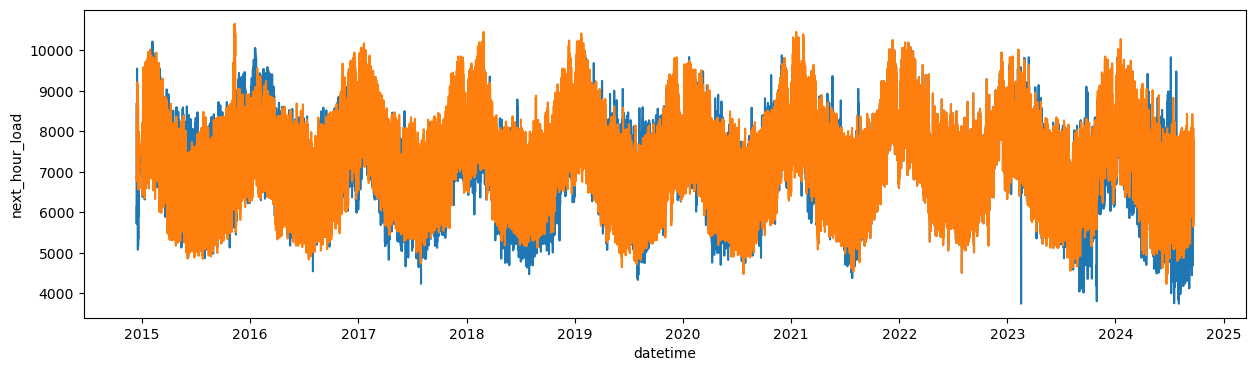

In [49]:
plt.figure(figsize=(15,4))
sns.lineplot(x=df.index, y='next_hour_load', data=df)
sns.lineplot(x=df.index, y='next_hour_forecast', data=df)

In [179]:
# Dump
df.to_parquet('data/clean/df.parquet')